In [152]:
import os
import cx_Oracle
import pandas as pd
import numpy as np
import pickle
from datetime import date,datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score 
import time
import matplotlib.pyplot as plt
from sklearn.utils import resample
import datetime

In [153]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN")

In [154]:
df = pd.read_pickle(os.getcwd()+r"\Data Files\final_grids_combined.pkl")

In [155]:
df=df[df["NTC_FLAG"] == 'NTC']

In [5]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FPD10,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,NTC_FLAG,GRID_ID,RISK_SCORE
86,299690313,2020-03-18,26.895303,75.750557,0.0,0.0,0.0,0.0,0.0,0.0,NTC,500_01551_04295,0.094270
204,299688050,2020-03-18,27.199507,78.019478,0.0,0.0,0.0,0.0,0.0,0.0,NTC,500_01994_04352,0.203476
297,299689543,2020-03-18,21.250473,81.671461,0.0,0.0,0.0,0.0,0.0,0.0,NTC,500_02720_03058,0.161592
345,299686222,2020-03-18,25.441833,75.640776,0.0,0.0,0.0,0.0,0.0,0.0,NTC,500_01519_03980,0.087024
388,299685049,2020-03-18,23.260509,77.394133,0.0,0.0,0.0,0.0,0.0,0.0,NTC,500_01857_03498,NaN


In [6]:
df["RISK_SCORE"].isna().value_counts()

True     3814239
False    3136854
Name: RISK_SCORE, dtype: int64

In [7]:
df["MONTH_STR"] = df["TIME_DECISION_DATE"].dt.strftime("%Y-%m")
df_summ = df[["MONTH_STR","RISK_FSTQPD30"]].groupby("MONTH_STR").aggregate(["count","sum"])["RISK_FSTQPD30"]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

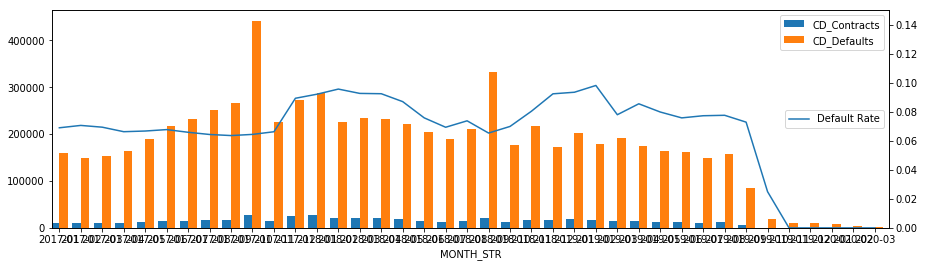

In [8]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.15)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")


plt.show()


# Generate grid based scores for selected variables

In [15]:
hyper_df= pd.read_csv(os.getcwd()+r"\Data Files\Hyperparameters\Hyperparameters_new.csv")

In [16]:
hyper_df.head()

,SCORE_NAME,TARGET,K,OBSERVATION_WINDOW,PERFORMANCE_WINDOW,DOWNSAMPLE_SIZE,FILLNA
0,RISK_FPD10_SCORE,RISK_FPD10,211,365,40,80000,0.503123
1,RISK_FPD30_SCORE,RISK_FPD30,146,365,60,30000,0.485446
2,RISK_FSPD30_SCORE,RISK_FSPD30,201,365,90,70000,0.493708
3,RISK_FSTPD30_SCORE,RISK_FSTPD30,291,365,120,120000,0.501129
4,RISK_FSTQPD30_SCORE,RISK_FSTQPD30,351,365,150,200000,0.514893


In [17]:
selected_list =['NO_PAYMENT_CURRENT_PAYMENT_1', 'DEFAULT_FLAG_CHANGE_1', 'RISK_FSTQPD30_SCORE', 'RISK_FSPD30_MM_SCORE']

In [18]:
# hyper_df= pd.read_csv(os.getcwd()+r"\Data Files\Hyperparameters.csv")
# df = pd.read_csv(os.getcwd()+r"\Data Files\final_grids.csv")
# df["TIME_DECISION_DATE"]=pd.to_datetime(df["TIME_DECISION_DATE"],format = '%d-%m-%y')

In [19]:
import datetime
from sklearn.neighbors import KNeighborsClassifier

df_final_test = pd.DataFrame()

for x in np.arange(1,9,1):
    date_test_start = datetime.datetime(2019, x, 1)
    date_test_end = (date_test_start +  datetime.timedelta(days=31)).replace(day=1)
    df_test = df[(df["TIME_DECISION_DATE"]>=date_test_start) & 
                      (df["TIME_DECISION_DATE"]<date_test_end)]

    for y in hyper_df.index:
#         if hyper_df.loc[y,'SCORE_NAME'] in selected_list:
        if True:
            score_name = hyper_df.loc[y,'SCORE_NAME']
            target = hyper_df.loc[y,'TARGET']
            K = hyper_df.loc[y,'K']
            observation_window = hyper_df.loc[y,'OBSERVATION_WINDOW']
            performance_window = hyper_df.loc[y,'PERFORMANCE_WINDOW']
            downsample_size = hyper_df.loc[y,'DOWNSAMPLE_SIZE']
            fillna = hyper_df.loc[y,'FILLNA']

            date_train_start = (date_test_start-datetime.timedelta(days=int(performance_window))-datetime.timedelta(days=int(observation_window))) 
            date_train_end = (date_test_start-datetime.timedelta(days=int(performance_window)))
            start_time = datetime.datetime.now()
            df_train = df[(df["TIME_DECISION_DATE"]>=date_train_start) & 
                      (df["TIME_DECISION_DATE"]<date_train_end)]

            df_class_0 = df_train[df_train[target] == 0]
            df_class_1 = df_train[df_train[target] == 1]
            df_class_0_under = df_class_0.sample(min(downsample_size,df_class_1.shape[0]))
            df_class_1_under = df_class_1.sample(min(downsample_size,df_class_1.shape[0]))
            df_train_under = pd.concat([df_class_0_under, df_class_1_under], axis=0)

            X_train = df_train_under[["CUS_LAT","CUS_LONG"]]
            X_test = df_test[["CUS_LAT","CUS_LONG"]]
            y_train = df_train_under[target]
            y_test =  df_test[target]

            knn = KNeighborsClassifier(n_neighbors = K)
            bst = knn.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))

            ypred_train = bst.predict_proba(X_train[["CUS_LAT","CUS_LONG"]])[:, 1]
            ypred_test = bst.predict_proba(X_test[["CUS_LAT","CUS_LONG"]])[:, 1]
            metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
            metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)
            gini_train = 2 * metric_auc_train - 1
            gini_test = 2 * metric_auc_test - 1

            df_test[score_name] = ypred_test
            
            df_train_under ["G_"+score_name] = ypred_train
            grid_score = df_train_under[["GRID_ID","G_"+score_name]].groupby("GRID_ID").mean()["G_"+score_name].reset_index()
            grid_score.columns = ['GRID_ID',"G_"+score_name]
            
            df_test = pd.merge(df_test, grid_score, on = 'GRID_ID', how = 'left')
            df_test["G_"+score_name]=df_test["G_"+score_name].fillna(value = fillna)
            
            print("Training for predicting (month):",date_test_start.month, 
                  " SCORE:",score_name,
                  " target:",target,
                  " K:",K,
                  " observation_window:",observation_window,
                  " performance_window:",performance_window,
                  " downsample_size:",downsample_size,
                  " GINI TRAIN:",'{:,.2%}'.format(gini_train), "    GINI TEST:",'{:,.2%}'.format(gini_test),
                  " time taken: ",'{:,.2}'.format((datetime.datetime.now()-start_time).seconds/60))


    if df_final_test.shape == (0,0):
        df_final_test = df_test
    else:
        df_final_test = pd.concat([df_final_test,df_test],ignore_index=True)


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 1  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 211  observation_window: 365  performance_window: 40  downsample_size: 80000  GINI TRAIN: 15.85%     GINI TEST: 11.72%  time taken:  0.48
Training for predicting (month): 1  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 146  observation_window: 365  performance_window: 60  downsample_size: 30000  GINI TRAIN: 21.15%     GINI TEST: 15.17%  time taken:  0.22
Training for predicting (month): 1  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 201  observation_window: 365  performance_window: 90  downsample_size: 70000  GINI TRAIN: 19.07%     GINI TEST: 12.63%  time taken:  0.38
Training for predicting (month): 1  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 291  observation_window: 365  performance_window: 120  downsample_size: 120000  GINI TRAIN: 17.11%     GINI TEST: 12.87%  time taken:  0.78
Training for predicting (month): 1  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 351  observati

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 2  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 211  observation_window: 365  performance_window: 40  downsample_size: 80000  GINI TRAIN: 15.91%     GINI TEST: 11.37%  time taken:  0.4
Training for predicting (month): 2  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 146  observation_window: 365  performance_window: 60  downsample_size: 30000  GINI TRAIN: 20.77%     GINI TEST: 16.76%  time taken:  0.18
Training for predicting (month): 2  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 201  observation_window: 365  performance_window: 90  downsample_size: 70000  GINI TRAIN: 18.83%     GINI TEST: 14.88%  time taken:  0.35
Training for predicting (month): 2  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 291  observation_window: 365  performance_window: 120  downsample_size: 120000  GINI TRAIN: 17.05%     GINI TEST: 13.06%  time taken:  0.72
Training for predicting (month): 2  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 351  observatio

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 3  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 211  observation_window: 365  performance_window: 40  downsample_size: 80000  GINI TRAIN: 15.93%     GINI TEST: 12.91%  time taken:  0.38
Training for predicting (month): 3  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 146  observation_window: 365  performance_window: 60  downsample_size: 30000  GINI TRAIN: 20.58%     GINI TEST: 18.39%  time taken:  0.2
Training for predicting (month): 3  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 201  observation_window: 365  performance_window: 90  downsample_size: 70000  GINI TRAIN: 18.73%     GINI TEST: 14.30%  time taken:  0.35
Training for predicting (month): 3  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 291  observation_window: 365  performance_window: 120  downsample_size: 120000  GINI TRAIN: 16.94%     GINI TEST: 12.36%  time taken:  0.7
Training for predicting (month): 3  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 351  observation

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 4  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 211  observation_window: 365  performance_window: 40  downsample_size: 80000  GINI TRAIN: 15.92%     GINI TEST: 12.98%  time taken:  0.37
Training for predicting (month): 4  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 146  observation_window: 365  performance_window: 60  downsample_size: 30000  GINI TRAIN: 20.67%     GINI TEST: 15.86%  time taken:  0.17
Training for predicting (month): 4  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 201  observation_window: 365  performance_window: 90  downsample_size: 70000  GINI TRAIN: 18.65%     GINI TEST: 13.62%  time taken:  0.35
Training for predicting (month): 4  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 291  observation_window: 365  performance_window: 120  downsample_size: 120000  GINI TRAIN: 16.49%     GINI TEST: 11.60%  time taken:  0.68
Training for predicting (month): 4  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 351  observati

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 5  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 211  observation_window: 365  performance_window: 40  downsample_size: 80000  GINI TRAIN: 16.47%     GINI TEST: 10.48%  time taken:  0.72
Training for predicting (month): 5  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 146  observation_window: 365  performance_window: 60  downsample_size: 30000  GINI TRAIN: 20.56%     GINI TEST: 15.76%  time taken:  0.27
Training for predicting (month): 5  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 201  observation_window: 365  performance_window: 90  downsample_size: 70000  GINI TRAIN: 18.66%     GINI TEST: 13.19%  time taken:  0.48
Training for predicting (month): 5  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 291  observation_window: 365  performance_window: 120  downsample_size: 120000  GINI TRAIN: 16.71%     GINI TEST: 10.66%  time taken:  1.1
Training for predicting (month): 5  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 351  observatio

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 6  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 211  observation_window: 365  performance_window: 40  downsample_size: 80000  GINI TRAIN: 16.56%     GINI TEST: 10.20%  time taken:  0.65
Training for predicting (month): 6  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 146  observation_window: 365  performance_window: 60  downsample_size: 30000  GINI TRAIN: 20.93%     GINI TEST: 15.56%  time taken:  0.32
Training for predicting (month): 6  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 201  observation_window: 365  performance_window: 90  downsample_size: 70000  GINI TRAIN: 18.67%     GINI TEST: 12.86%  time taken:  0.58
Training for predicting (month): 6  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 291  observation_window: 365  performance_window: 120  downsample_size: 120000  GINI TRAIN: 16.69%     GINI TEST: 9.66%  time taken:  1.1
Training for predicting (month): 6  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 351  observation

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 7  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 211  observation_window: 365  performance_window: 40  downsample_size: 80000  GINI TRAIN: 16.88%     GINI TEST: 7.64%  time taken:  0.63
Training for predicting (month): 7  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 146  observation_window: 365  performance_window: 60  downsample_size: 30000  GINI TRAIN: 20.91%     GINI TEST: 11.80%  time taken:  0.28
Training for predicting (month): 7  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 201  observation_window: 365  performance_window: 90  downsample_size: 70000  GINI TRAIN: 19.32%     GINI TEST: 9.24%  time taken:  0.55
Training for predicting (month): 7  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 291  observation_window: 365  performance_window: 120  downsample_size: 120000  GINI TRAIN: 17.09%     GINI TEST: 7.27%  time taken:  1.1
Training for predicting (month): 7  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 351  observation_w

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 8  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 211  observation_window: 365  performance_window: 40  downsample_size: 80000  GINI TRAIN: 16.84%     GINI TEST: 8.75%  time taken:  0.63
Training for predicting (month): 8  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 146  observation_window: 365  performance_window: 60  downsample_size: 30000  GINI TRAIN: 21.39%     GINI TEST: 12.38%  time taken:  0.3
Training for predicting (month): 8  SCORE: RISK_FSPD30_SCORE  target: RISK_FSPD30  K: 201  observation_window: 365  performance_window: 90  downsample_size: 70000  GINI TRAIN: 19.77%     GINI TEST: 9.59%  time taken:  0.58
Training for predicting (month): 8  SCORE: RISK_FSTPD30_SCORE  target: RISK_FSTPD30  K: 291  observation_window: 365  performance_window: 120  downsample_size: 120000  GINI TRAIN: 16.98%     GINI TEST: 9.10%  time taken:  1.1
Training for predicting (month): 8  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 351  observation_wi

In [20]:
for y in hyper_df.index:
    score_name = hyper_df.loc[y,'SCORE_NAME']
    print(score_name, df_final_test[df_final_test["G_"+score_name].isna()][score_name].mean())

RISK_FPD10_SCORE nan
RISK_FPD30_SCORE nan
RISK_FSPD30_SCORE nan
RISK_FSTPD30_SCORE nan
RISK_FSTQPD30_SCORE nan
RISK_FPD10_MM_SCORE nan
RISK_FPD30_MM_SCORE nan
RISK_FSPD30_MM_SCORE nan
RISK_FSTPD30_MM_SCORE nan


In [21]:
print(2*metrics.roc_auc_score(df_final_test["RISK_FSTQPD30"],df_final_test["RISK_FSPD30_MM_SCORE"])-1)
print(2*metrics.roc_auc_score(df_final_test["RISK_FSTQPD30"],df_final_test["G_RISK_FSPD30_MM_SCORE"])-1)

print(2*metrics.roc_auc_score(df_final_test["RISK_FSTQPD30"],df_final_test["RISK_FSTQPD30_SCORE"])-1)
print(2*metrics.roc_auc_score(df_final_test["RISK_FSTQPD30"],df_final_test["G_RISK_FSTQPD30_SCORE"])-1)

0.04705637775650229
0.030402974748771294
0.09515022166483256
0.0926038454041147


In [73]:
df_final_test.to_pickle(os.getcwd()+r"\Data Files\delinquency_scores_2019_new.pkl")

In [156]:
df_final_test = pd.read_pickle(os.getcwd()+r"\Data Files\delinquency_scores_2019_new.pkl")

In [157]:
df1 = pd.read_pickle(os.getcwd()+r"\Data Files\delinquency_scores_2019.pkl")
df1.columns = ['SKP_CREDIT_CASE', 'TIME_DECISION_DATE', 'CUS_LAT', 'CUS_LONG',
       'RISK_FPD10', 'RISK_FPD30', 'RISK_FSPD30', 'RISK_FSTPD30',
       'RISK_FSTQPD30', 'RISK_FSTQPD60', 'NTC_FLAG', 'GRID_ID', 'RISK_SCORE',
       'C_RISK_FPD10_SCORE', 'C_G_RISK_FPD10_SCORE', 'C_RISK_FPD30_SCORE',
       'C_G_RISK_FPD30_SCORE', 'C_RISK_FSPD30_SCORE', 'C_G_RISK_FSPD30_SCORE',
       'C_RISK_FSTPD30_SCORE', 'C_G_RISK_FSTPD30_SCORE', 'C_RISK_FSTQPD30_SCORE',
       'C_G_RISK_FSTQPD30_SCORE', 'C_RISK_FPD10_MM_SCORE', 'C_G_RISK_FPD10_MM_SCORE',
       'C_RISK_FPD30_MM_SCORE', 'C_G_RISK_FPD30_MM_SCORE', 'C_RISK_FSPD30_MM_SCORE',
       'C_G_RISK_FSPD30_MM_SCORE', 'C_RISK_FSTPD30_MM_SCORE',
       'C_G_RISK_FSTPD30_MM_SCORE']

In [158]:
merge_columns = ['SKP_CREDIT_CASE', 'C_RISK_FPD10_SCORE', 'C_G_RISK_FPD10_SCORE', 'C_RISK_FPD30_SCORE',
       'C_G_RISK_FPD30_SCORE', 'C_RISK_FSPD30_SCORE', 'C_G_RISK_FSPD30_SCORE',
       'C_RISK_FSTPD30_SCORE', 'C_G_RISK_FSTPD30_SCORE', 'C_RISK_FSTQPD30_SCORE',
       'C_G_RISK_FSTQPD30_SCORE', 'C_RISK_FPD10_MM_SCORE', 'C_G_RISK_FPD10_MM_SCORE',
       'C_RISK_FPD30_MM_SCORE', 'C_G_RISK_FPD30_MM_SCORE', 'C_RISK_FSPD30_MM_SCORE',
       'C_G_RISK_FSPD30_MM_SCORE', 'C_RISK_FSTPD30_MM_SCORE', 'C_G_RISK_FSTPD30_MM_SCORE']

In [159]:
df= df_final_test.merge(df1[merge_columns], on = 'SKP_CREDIT_CASE',how = 'inner')

In [160]:
df2 = pd.read_pickle(os.getcwd()+r"\Data Files\emi_payment_scores_2019.pkl")

In [161]:
merge_columns = ['SKP_CREDIT_CASE',  'DEFAULT_FLAG_CHANGE_1', 'DEFAULT_FLAG_CHANGE_2',
       'DEFAULT_FLAG_CHANGE_3', 'DEFAULT_FLAG_CHANGE_4',
       'DEFAULT_FLAG_CHANGE_5', 'G_DEFAULT_FLAG_CHANGE_1',
       'G_DEFAULT_FLAG_CHANGE_2', 'G_DEFAULT_FLAG_CHANGE_3',
       'G_DEFAULT_FLAG_CHANGE_4', 'G_DEFAULT_FLAG_CHANGE_5',
       'G_NO_PAYMENT_CURRENT_PAYMENT_1', 'G_NO_PAYMENT_CURRENT_PAYMENT_2',
       'G_NO_PAYMENT_CURRENT_PAYMENT_3', 'G_NO_PAYMENT_CURRENT_PAYMENT_4',
       'G_NO_PAYMENT_CURRENT_PAYMENT_5', 'NO_PAYMENT_CURRENT_PAYMENT_1',
       'NO_PAYMENT_CURRENT_PAYMENT_2', 'NO_PAYMENT_CURRENT_PAYMENT_3',
       'NO_PAYMENT_CURRENT_PAYMENT_4', 'NO_PAYMENT_CURRENT_PAYMENT_5']

In [162]:
df= df.merge(df2[merge_columns], on = 'SKP_CREDIT_CASE',how = 'inner')

In [163]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FPD10,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,...,G_NO_PAYMENT_CURRENT_PAYMENT_1,G_NO_PAYMENT_CURRENT_PAYMENT_2,G_NO_PAYMENT_CURRENT_PAYMENT_3,G_NO_PAYMENT_CURRENT_PAYMENT_4,G_NO_PAYMENT_CURRENT_PAYMENT_5,NO_PAYMENT_CURRENT_PAYMENT_1,NO_PAYMENT_CURRENT_PAYMENT_2,NO_PAYMENT_CURRENT_PAYMENT_3,NO_PAYMENT_CURRENT_PAYMENT_4,NO_PAYMENT_CURRENT_PAYMENT_5
0,223799321,2019-02-01,30.867149,75.930356,0.0,0.0,0.0,0.0,0.0,0.0,...,0.457684,NaN,NaN,NaN,NaN,0.464387,NaN,NaN,NaN,NaN
1,223889994,2019-02-01,28.569622,77.286007,0.0,0.0,0.0,0.0,0.0,0.0,...,0.480780,NaN,NaN,NaN,NaN,0.481481,NaN,NaN,NaN,NaN
2,223889995,2019-02-01,23.204827,77.442296,0.0,0.0,0.0,0.0,0.0,0.0,...,0.650047,NaN,NaN,NaN,NaN,0.646724,NaN,NaN,NaN,NaN
3,223890202,2019-02-01,28.607001,77.320596,0.0,0.0,0.0,0.0,0.0,0.0,...,0.521740,NaN,NaN,NaN,NaN,0.518519,NaN,NaN,NaN,NaN
4,223890203,2019-02-01,19.117477,72.863350,0.0,0.0,0.0,0.0,0.0,0.0,...,0.452991,NaN,NaN,NaN,NaN,0.441595,NaN,NaN,NaN,NaN


In [164]:
df.shape

(1176780, 70)

In [165]:
scores_columns= [x for x in df.columns if 'SCORE' in x and 'G' in x]
scores_columns = scores_columns + ['G_NO_PAYMENT_CURRENT_PAYMENT_1', 'G_NO_PAYMENT_CURRENT_PAYMENT_2',
                                   'G_DEFAULT_FLAG_CHANGE_1', 'G_DEFAULT_FLAG_CHANGE_2']

# Convert All Scores to Logit

In [166]:
df.dropna(subset = ['RISK_SCORE'], inplace = True)
for y in scores_columns:
    df["LOGIT_"+y] = [np.log(x/(1-x)) for x in df[y]]

In [167]:
logit_columns= [x for x in df.columns if 'LOGIT' in x]

In [168]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

In [169]:
df_train = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019,3,1)) 
               & (df["TIME_DECISION_DATE"]<=datetime.datetime(2019,4,30))]
df_test = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019,5,1)) 
               & (df["TIME_DECISION_DATE"]<=datetime.datetime(2019,8,30))]

# Use Forward Selection

In [95]:
logit_columns = [
 'LOGIT_C_G_RISK_FPD10_SCORE',
 'LOGIT_C_G_RISK_FPD30_SCORE',
 'LOGIT_C_G_RISK_FSPD30_SCORE',
 'LOGIT_C_G_RISK_FSTPD30_SCORE',
 'LOGIT_C_G_RISK_FSTQPD30_SCORE',
 'LOGIT_C_G_RISK_FPD10_MM_SCORE',
 'LOGIT_C_G_RISK_FPD30_MM_SCORE',
 'LOGIT_C_G_RISK_FSPD30_MM_SCORE',
 'LOGIT_C_G_RISK_FSTPD30_MM_SCORE',
 'LOGIT_G_NO_PAYMENT_CURRENT_PAYMENT_1',
 'LOGIT_G_NO_PAYMENT_CURRENT_PAYMENT_2',
 'LOGIT_G_DEFAULT_FLAG_CHANGE_1',
 'LOGIT_G_DEFAULT_FLAG_CHANGE_2']

In [96]:
import sys
sys.path.append(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Scoring Worlflow")
from scoring.model_selection import GiniStepwiseLogit

modelSW = GiniStepwiseLogit(initial_predictors = set(),
                            max_iter=1000,
                            min_increase=0.05,
                            max_decrease=0.025,
                            max_predictors=0, 
                            max_correlation=1, 
                            beta_sgn_criterion=False, 
                            penalty='l2', C=10e10, 
                            correlation_sample=10000,
                            selection_method='stepwise',
                            use_cv=True,
                            cv_folds=3, 
                            cv_seed=98765)

modelSW.fit(df_train[logit_columns], df_train['RISK_FSTQPD30']
       # ,sample_weight = data[train_mask][col_weight], sample_weight_valid = data[valid_mask][col_weight]
       )

Cross validation will be used for the training sample.
Iteration  0
set()
Achieved Gini:  0
Iteration  1
{'LOGIT_C_G_RISK_FSTQPD30_SCORE'}
Achieved Gini:  10.393841746661266
Iteration  2
{'LOGIT_C_G_RISK_FSTQPD30_SCORE', 'LOGIT_C_G_RISK_FPD10_MM_SCORE'}
Achieved Gini:  10.476769395681629
Iteration  3
{'LOGIT_C_G_RISK_FSTQPD30_SCORE', 'LOGIT_G_DEFAULT_FLAG_CHANGE_1', 'LOGIT_C_G_RISK_FPD10_MM_SCORE'}
Achieved Gini:  10.536803958552781
Iteration  4
{'LOGIT_C_G_RISK_FSTQPD30_SCORE', 'LOGIT_G_NO_PAYMENT_CURRENT_PAYMENT_1', 'LOGIT_G_DEFAULT_FLAG_CHANGE_1', 'LOGIT_C_G_RISK_FPD10_MM_SCORE'}
Achieved Gini:  10.675988321117089
Iteration  5
{'LOGIT_C_G_RISK_FSTQPD30_SCORE', 'LOGIT_G_NO_PAYMENT_CURRENT_PAYMENT_1', 'LOGIT_G_DEFAULT_FLAG_CHANGE_1', 'LOGIT_C_G_RISK_FPD10_MM_SCORE'}
Achieved Gini:  10.675988321117089


GiniStepwiseLogit(C=100000000000.0, beta_sgn_criterion=False,
         correlation_sample=10000, cv_folds=3, cv_seed=98765,
         initial_predictors=set(), max_correlation=1, max_decrease=0.025,
         max_iter=1000, max_predictors=0, min_increase=0.05, penalty='l2',
         selection_method='stepwise', use_cv=True)

In [104]:
imp =['LOGIT_C_G_RISK_FSTQPD30_SCORE', 'LOGIT_G_NO_PAYMENT_CURRENT_PAYMENT_1', 'LOGIT_G_DEFAULT_FLAG_CHANGE_1', 'LOGIT_C_G_RISK_FPD10_MM_SCORE']

# Generate final combined Score

In [129]:
model= LogisticRegression(penalty = 'l1' , C=1)

In [130]:
model.fit(df_train[imp], df_train["RISK_FSTQPD30"])

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [131]:
pd.DataFrame({'coeff': model.coef_[0], 'logit_columns': imp})

,coeff,logit_columns
0,0.495134,LOGIT_C_G_RISK_FSTQPD30_SCORE
1,0.246826,LOGIT_G_NO_PAYMENT_CURRENT_PAYMENT_1
2,0.128352,LOGIT_G_DEFAULT_FLAG_CHANGE_1
3,0.123364,LOGIT_C_G_RISK_FPD10_MM_SCORE


In [132]:
model.intercept_

array([-2.37891549])

In [127]:
print(2*metrics.roc_auc_score(df_test['RISK_FSTQPD30'],model.predict_proba(df_test[imp])[:,1])-1)

0.09480313827137676


In [122]:
print(2*metrics.roc_auc_score(df_test['RISK_FSTQPD30'],df_test['G_RISK_FSTQPD30_SCORE'])-1)

0.08212330621771868


In [111]:
len(logit_columns)

13

In [416]:
#Save Combined Score for 2nd to 8th Month

In [170]:
df1= df[df["TIME_DECISION_DATE"]>=datetime.datetime(2019,3,1)][["SKP_CREDIT_CASE","TIME_DECISION_DATE",
                                                               "CUS_LAT","CUS_LONG","GRID_ID","RISK_FSTQPD30","RISK_SCORE",
                                                              'NO_PAYMENT_CURRENT_PAYMENT_1','C_RISK_FPD10_SCORE',
                                                                'C_RISK_FPD10_MM_SCORE','NO_PAYMENT_CURRENT_PAYMENT_2',
                                                                'DEFAULT_FLAG_CHANGE_1','C_RISK_FSTQPD30_SCORE',
                                                                'C_RISK_FPD30_SCORE','G_NO_PAYMENT_CURRENT_PAYMENT_1',
                                                                'C_G_RISK_FPD10_SCORE','C_G_RISK_FPD10_MM_SCORE','G_NO_PAYMENT_CURRENT_PAYMENT_2',
                                                                'G_DEFAULT_FLAG_CHANGE_1','C_G_RISK_FSTQPD30_SCORE','C_G_RISK_FPD30_SCORE',
                                                                'LOGIT_G_NO_PAYMENT_CURRENT_PAYMENT_1','LOGIT_C_G_RISK_FPD10_SCORE',
                                                                'LOGIT_C_G_RISK_FPD10_MM_SCORE','LOGIT_G_NO_PAYMENT_CURRENT_PAYMENT_2',
                                                                'LOGIT_G_DEFAULT_FLAG_CHANGE_1','LOGIT_C_G_RISK_FSTQPD30_SCORE','LOGIT_C_G_RISK_FPD30_SCORE'
                                                              ]]

In [136]:
df1["COMBINED_SCORE_KNN"] = model.predict_proba(df1[imp])[:,1]

In [171]:
df1["COMBINED_SCORE_KNN"] = 1/(1+np.exp(-(df1["LOGIT_C_G_RISK_FSTQPD30_SCORE"]*0.495134+ 
              df1["LOGIT_G_NO_PAYMENT_CURRENT_PAYMENT_1"]*0.246826 +
                df1["LOGIT_G_DEFAULT_FLAG_CHANGE_1"]*0.128352 +
              df1["LOGIT_C_G_RISK_FPD10_MM_SCORE"]*0.123364 +  -2.37891549)))

In [172]:
print("GINI COMBINED: ",'{:,.2%}'.format(2 * metrics.roc_auc_score(df1["RISK_FSTQPD30"], df1["COMBINED_SCORE_KNN"]) - 1))

GINI COMBINED:  9.92%


In [3]:
import numpy as np
default_score = 1/(1+np.exp(-(np.log(0.526039/(1-0.526039))*0.495134+ 
              np.log(0.496491/(1-0.496491))*0.123364 +
                np.log(0.540940336/(1-0.540940336))*0.128352 +
              np.log(0.481199645/(1-0.481199645))*0.246826 +  -2.37891549)))

In [4]:
default_score

0.08894919166065231

In [4]:
np.log(10)

2.302585092994046

# Create combined Score with RISK Score

In [185]:
df1["LOGIT_RISK_SCORE"] = [np.log(x/(1-x)) for x in df1["RISK_SCORE"]]
df1["LOGIT_COMBINED_SCORE_KNN"] = [np.log(x/(1-x)) for x in df1["COMBINED_SCORE_KNN"]]


In [186]:
model= LogisticRegression(penalty = 'l1' , C=1)

In [187]:
model.fit(df1[df1["TIME_DECISION_DATE"]<datetime.datetime(2019,5,1)][["LOGIT_RISK_SCORE","LOGIT_COMBINED_SCORE_KNN"]], df1[df1["TIME_DECISION_DATE"]<datetime.datetime(2019,5,1)]["RISK_FSTQPD30"])

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [188]:
pd.DataFrame({'coeff': model.coef_[0], 'logit_columns': ["LOGIT_RISK_SCORE","LOGIT_COMBINED_SCORE_KNN"] })

,coeff,logit_columns
0,0.616961,LOGIT_RISK_SCORE
1,0.828145,LOGIT_COMBINED_SCORE_KNN


In [189]:
model.intercept_

array([0.69135326])

In [190]:
df1["COMBINED_SCORE"] = model.predict_proba(df1[["LOGIT_RISK_SCORE","LOGIT_COMBINED_SCORE_KNN"]])[:,1]

In [191]:
df1["COMBINED_SCORE"] = 1/(1+np.exp(-(df1["LOGIT_RISK_SCORE"]*0.617087+ 
              df1["LOGIT_COMBINED_SCORE_KNN"]*0.828352 + 0.69204446)))

In [192]:
print("GINI COMBINED: ",'{:,.2%}'.format(2 * metrics.roc_auc_score(df1["RISK_FSTQPD30"], df1["COMBINED_SCORE"]) - 1))
print("GINI COMBINED: ",'{:,.2%}'.format(2 * metrics.roc_auc_score(df1["RISK_FSTQPD30"], df1["RISK_SCORE"]) - 1))

GINI COMBINED:  19.57%
GINI COMBINED:  17.80%


In [177]:
df1.to_pickle(os.getcwd()+"\Data Files\Combined Score_new.pkl")

# Correctly Scale RISK Score

In [193]:
df1["LOGIT_RISK_SCORE"] = [np.log(x/(1-x)) for x in df1["RISK_SCORE"]]
df1["LOGIT_COMBINED_SCORE_KNN"] = [np.log(x/(1-x)) for x in df1["COMBINED_SCORE_KNN"]]


In [194]:
model= LogisticRegression(penalty = 'l1' , C=1)

In [195]:
model.fit(df1[df1["TIME_DECISION_DATE"]<datetime.datetime(2019,5,1)][["LOGIT_RISK_SCORE"]], df1[df1["TIME_DECISION_DATE"]<datetime.datetime(2019,5,1)]["RISK_FSTQPD30"])

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [196]:
pd.DataFrame({'coeff': model.coef_[0], 'logit_columns': ["LOGIT_RISK_SCORE"] })

,coeff,logit_columns
0,0.655804,LOGIT_RISK_SCORE


In [197]:
model.intercept_

array([-1.23188016])

In [198]:
df1["RISK_SCORE_SCALED"] = model.predict_proba(df1[["LOGIT_RISK_SCORE"]])[:,1]

In [199]:
df1.to_pickle(os.getcwd()+"\Data Files\Combined Score_new.pkl")